# Routing, speed imputation, and travel times

Author: [Geoff Boeing](https://geoffboeing.com/)

  - [Overview of OSMnx](http://geoffboeing.com/2016/11/osmnx-python-street-networks/)
  - [GitHub repo](https://github.com/gboeing/osmnx)
  - [Examples, demos, tutorials](https://github.com/gboeing/osmnx-examples)
  - [Documentation](https://osmnx.readthedocs.io/en/stable/)
  - [Journal article/citation](http://geoffboeing.com/publications/osmnx-complex-street-networks/)

In [1]:
import networkx as nx
import osmnx as ox
%matplotlib inline
ox.config(use_cache=True, log_console=True)
ox.__version__

'0.14.0'

In [2]:
place = 'Piedmont, California, USA'
G = ox.graph_from_place(place, network_type='drive')

## 1. Fast nearest node/edge search with OSMnx

In [3]:
# convert graph to geodataframes
gdf_edges = ox.graph_to_gdfs(G, nodes=False)

# list of lats and lngs
lngs = gdf_edges.head().centroid.map(lambda x: x.coords[0][0])
lats = gdf_edges.head().centroid.map(lambda x: x.coords[0][1])

# the lat, lng at the spatial center of the graph
lng, lat = gdf_edges.unary_union.centroid.coords[0]
center_point = lat, lng

In [4]:
# find the nearest node to some point
center_node = ox.get_nearest_node(G, center_point)

In [5]:
# find the nearest nodes to a set of points
# optionally specify `method` use use a kdtree or balltree index
nearest_nodes = ox.get_nearest_nodes(G, lngs, lats, method='balltree')

In [6]:
# find the nearest edge to some point
nearest_edge = ox.get_nearest_edge(G, center_point)

In [7]:
# find the nearest edges to some set of points
# optionally specify `method` use use a kdtree or balltree index
nearest_edges = ox.get_nearest_edges(G, lngs, lats)

## 2. Basic routing by distance

Pick two nodes. Then find the shortest path between origin and destination, using weight='length' to find the shortest path by minimizing distance traveled (otherwise it treats each edge as weight=1).

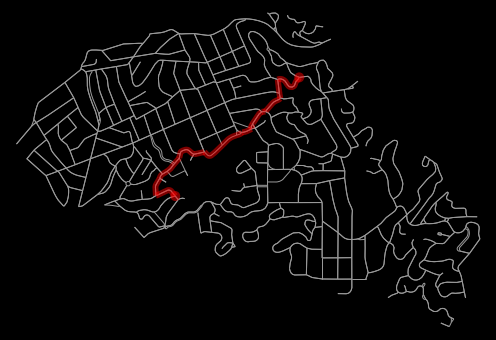

In [8]:
# find the shortest path (by distance) between these nodes then plot it
orig = list(G)[0]
dest = list(G)[-1]
route = nx.shortest_path(G, orig, dest, weight='length')
fig, ax = ox.plot_graph_route(G, route, route_linewidth=6, node_size=0, bgcolor='k')

The routing correctly handles one-way streets:

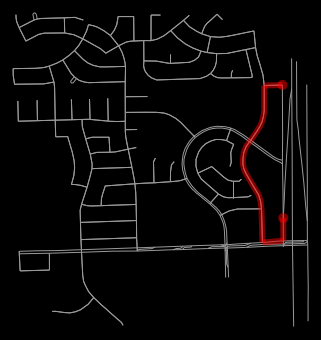

In [9]:
G2 = ox.graph_from_address('N. Sicily Pl., Chandler, Arizona', dist=800, network_type='drive')
origin = (33.307792, -111.894940)
destination = (33.312994, -111.894998)
origin_node = ox.get_nearest_node(G2, origin)
destination_node = ox.get_nearest_node(G2, destination)
route = nx.shortest_path(G2, origin_node, destination_node)
fig, ax = ox.plot_graph_route(G2, route, route_linewidth=6, node_size=0, bgcolor='k')

Also, when there are parallel edges between nodes in the route, OSMnx picks the shortest edge to plot:

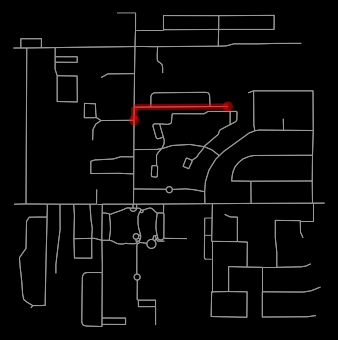

In [10]:
location_point = (33.299896, -111.831638)
G2 = ox.graph_from_point(location_point, dist=500, clean_periphery=False)
origin = (33.301821, -111.829871)
destination = (33.301402, -111.833108)
origin_node = ox.get_nearest_node(G2, origin)
destination_node = ox.get_nearest_node(G2, destination)
route = nx.shortest_path(G2, origin_node, destination_node)
fig, ax = ox.plot_graph_route(G2, route, route_linewidth=6, node_size=0, bgcolor='k')

## 3. Imputing travel speeds and times

The `add_edge_speeds` function add edge speeds (km per hour) to graph as new `speed_kph` edge attributes. Imputes free-flow travel speeds for all edges based on mean `maxspeed` value of edges, per highway type. This mean-imputation can obviously be imprecise, and the caller can override it by passing in `hwy_speeds` and/or `fallback` arguments that correspond to local speed limit standards. See docstring for details.

In [11]:
# impute speed on all edges missing data
G = ox.add_edge_speeds(G)

# calculate travel time (seconds) for all edges
G = ox.add_edge_travel_times(G)

In [12]:
# see mean speed/time values by road type
edges = ox.graph_to_gdfs(G, nodes=False)
edges['highway'] = edges['highway'].astype(str)
edges.groupby('highway')[['length', 'speed_kph', 'travel_time']].mean().round(1)

,length,speed_kph,travel_time
highway,,,
residential,126.5,24.1,18.9
secondary,120.6,44.3,9.9
tertiary,105.2,40.2,9.4
tertiary_link,64.6,36.2,6.4
unclassified,49.3,36.2,4.9


In [13]:
# same thing again, but this time pass in a few default speed values (km/hour)
# to fill in edges with missing `maxspeed` from OSM
hwy_speeds = {'residential': 35,
              'secondary': 50,
              'tertiary': 60}
G = ox.add_edge_speeds(G, hwy_speeds)
G = ox.add_edge_travel_times(G)

In [14]:
# calculate two routes by minimizing travel distance vs travel time
orig = list(G)[1]
dest = list(G)[-1]
route1 = nx.shortest_path(G, orig, dest, weight='length')
route2 = nx.shortest_path(G, orig, dest, weight='travel_time')

In [15]:
# compare the two routes
route1_length = int(sum(ox.utils_graph.get_route_edge_attributes(G, route1, 'length')))
route2_length = int(sum(ox.utils_graph.get_route_edge_attributes(G, route2, 'length')))
route1_time = int(sum(ox.utils_graph.get_route_edge_attributes(G, route1, 'travel_time')))
route2_time = int(sum(ox.utils_graph.get_route_edge_attributes(G, route2, 'travel_time')))
print('Route 1 is', route1_length, 'meters and takes', route1_time, 'seconds.')
print('Route 2 is', route2_length, 'meters and takes', route2_time, 'seconds.')

Route 1 is 1791 meters and takes 181 seconds.
Route 2 is 2263 meters and takes 172 seconds.


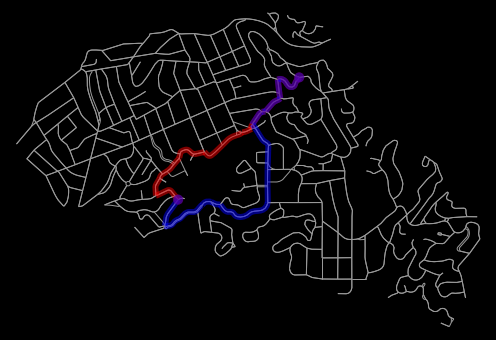

In [16]:
# pick route colors
c1 = 'r' #length
c2 = 'b' #travel_time
rc1 = [c1] * (len(route1) - 1)
rc2 = [c2] * (len(route2) - 1)
rc = rc1 + rc2
nc = [c1, c1, c2, c2]

# plot the routes
fig, ax = ox.plot_graph_routes(G, [route1, route2], route_color=rc, route_linewidth=6,
                               orig_dest_node_color=nc, node_size=0, bgcolor='k')

The blue route minimizes travel time, and is thus longer but faster than the red route.

For more examples of travel time, see the [isochrones example](13-isolines-isochrones.ipynb).

For more examples of routing, including using elevation as an impedance, see the [elevations example](12-node-elevations-edge-grades.ipynb).